###Import the Necessary Libraries

In [245]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
plt.style.use("ggplot")

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
from tensorflow.keras import optimizers

### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import math
from sklearn.metrics import mean_squared_error,r2_score

### Preprocessing Data

In [246]:
df = pd.read_csv("BTC-USD.csv",sep=',\s+', delimiter=',', encoding="utf-8", skipinitialspace=True)

In [247]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [248]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2551,11-09-2021,44869.83984,45969.29297,44818.26563,45201.45703,45201.45703,3.449984e+10
2552,12-09-2021,45206.62891,46364.87891,44790.46094,46063.26953,46063.26953,2.788198e+10
2553,13-09-2021,46057.21484,46598.67969,43591.32031,44963.07422,44963.07422,4.096994e+10
2554,14-09-2021,44960.05078,47218.12500,44752.33203,47092.49219,47092.49219,3.865215e+10
2555,15-09-2021,47134.28125,47861.94922,46773.32813,47707.02734,47707.02734,3.088304e+10


In [249]:
df.drop(['Close'],axis=1)

,Date,Open,High,Low,Adj Close,Volume
0,17-09-2014,465.864014,468.174011,452.421997,457.334015,2.105680e+07
1,18-09-2014,456.859985,456.859985,413.104004,424.440002,3.448320e+07
2,19-09-2014,424.102997,427.834991,384.532013,394.795990,3.791970e+07
3,20-09-2014,394.673004,423.295990,389.882996,408.903992,3.686360e+07
4,21-09-2014,408.084991,412.425995,393.181000,398.821014,2.658010e+07
...,...,...,...,...,...,...
2551,11-09-2021,44869.839840,45969.292970,44818.265630,45201.457030,3.449984e+10
2552,12-09-2021,45206.628910,46364.878910,44790.460940,46063.269530,2.788198e+10
2553,13-09-2021,46057.214840,46598.679690,43591.320310,44963.074220,4.096994e+10
2554,14-09-2021,44960.050780,47218.125000,44752.332030,47092.492190,3.865215e+10


In [250]:
df1=df.reset_index()['Adj Close']

In [251]:
df1.isnull().sum()

4

In [252]:
df1 = df1.dropna()

In [253]:
df1.isnull().sum()

0

In [254]:
df1

0         457.334015
1         424.440002
2         394.795990
3         408.903992
4         398.821014
            ...     
2551    45201.457030
2552    46063.269530
2553    44963.074220
2554    47092.492190
2555    47707.027340
Name: Adj Close, Length: 2552, dtype: float64

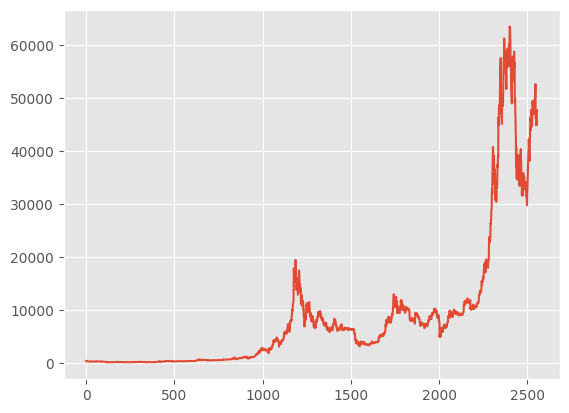

In [255]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [256]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

### Normalization Using MinMax Scaling

In [257]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [258]:
print(df1)

[[0.00440947]
 [0.00389002]
 [0.0034219 ]
 ...
 [0.70722023]
 [0.74084685]
 [0.75055126]]


In [283]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.80)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [284]:
training_size,test_size

(2041, 511)

In [285]:
train_data

array([[0.00440947],
       [0.00389002],
       [0.0034219 ],
       ...,
       [0.10957224],
       [0.11179664],
       [0.11071903]])

### Preparing the dataset

In [286]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [287]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [288]:
print(X_train.shape), print(y_train.shape)

(2020, 20)
(2020,)


(None, None)

In [289]:
print(X_test.shape), print(ytest.shape)

(490, 20)
(490,)


(None, None)

In [290]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

### Modelling

In [303]:
model=Sequential()
# model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
# model.add(LSTM(50,return_sequences=True))
# model.add(LSTM(50))
# model.add(Dense(1))

#adding layers to the model
model.add(LSTM(128,input_shape=(100,1),return_sequences=True))
model.add(LSTM(32,return_sequences = True))
model.add(LSTM(32))
model.add(Dense(64))
model.add(Dense(1))

#compiling model
lr=1e-3
model.compile(loss='mean_squared_error',optimizer = optimizers.Adam(lr = lr),metrics=['accuracy'])


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [304]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 100, 128)          66560     
_________________________________________________________________
lstm_31 (LSTM)               (None, 100, 32)           20608     
_________________________________________________________________
lstm_32 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 97,665
Trainable params: 97,665
Non-trainable params: 0
_________________________________________________________________


###Model fitting

In [305]:
res=model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
32/32 [==============================] - 7s 99ms/step - loss: 0.0011 - accuracy: 4.9505e-04 - val_loss: 0.0049 - val_accuracy: 0.0020
Epoch 2/100
32/32 [==============================] - 2s 64ms/step - loss: 1.8414e-04 - accuracy: 4.9505e-04 - val_loss: 0.0128 - val_accuracy: 0.0020
Epoch 3/100
32/32 [==============================] - 2s 65ms/step - loss: 1.6965e-04 - accuracy: 4.9505e-04 - val_loss: 0.0189 - val_accuracy: 0.0020
Epoch 4/100
32/32 [==============================] - 2s 64ms/step - loss: 1.6790e-04 - accuracy: 4.9505e-04 - val_loss: 0.0206 - val_accuracy: 0.0020
Epoch 5/100
32/32 [==============================] - 2s 64ms/step - loss: 1.4286e-04 - accuracy: 4.9505e-04 - val_loss: 0.0140 - val_accuracy: 0.0020
Epoch 6/100
32/32 [==============================] - 2s 64ms/step - loss: 1.3031e-04 - accuracy: 4.9505e-04 - val_loss: 0.0251 - val_accuracy: 0.0020
Epoch 7/100
32/32 [==============================] - 2s 63ms/step - loss: 1.3276e-04 - accuracy: 4.9505e

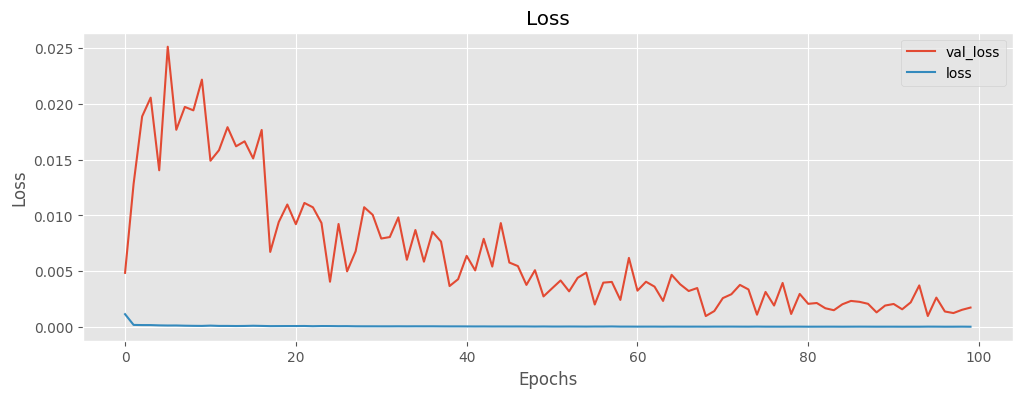

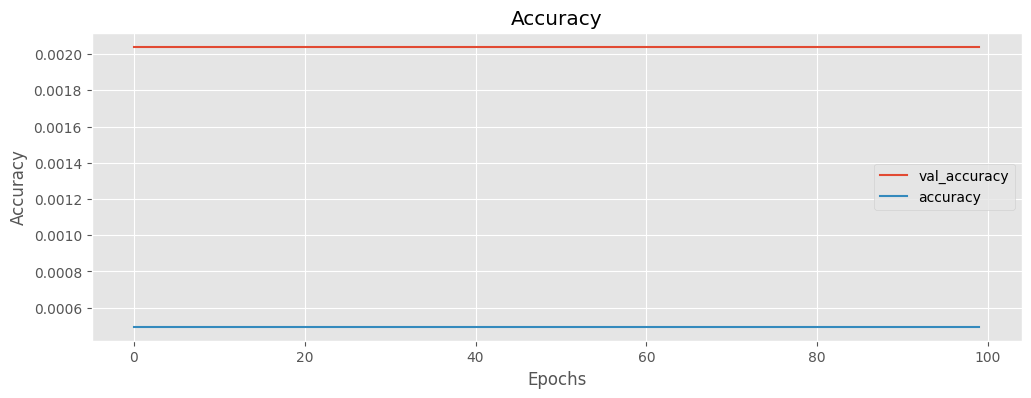

In [306]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

visualize_training_results(res)

In [307]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [308]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

### Performance metrics

In [309]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train,train_predict))

5645.051807661884

In [310]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

32464.665990395897

In [311]:
#R2 Score Metrics for training data 
r2_score(y_train, train_predict)

-8041081221.015406

In [312]:
#R2 Score Metrics for testing data 
r2_score(ytest, test_predict)

-13734592122.724792

###Plotting the graph

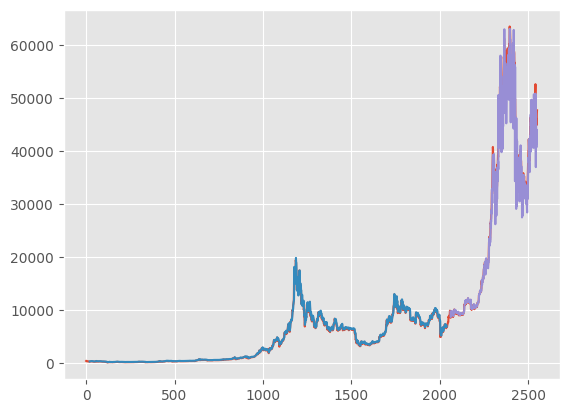

In [301]:
# ### Plotting 
# # shift train predictions for plotting
# look_back=20
# trainPredictPlot = numpy.empty_like(df1)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(df1)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict

# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(df1))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

In [278]:
# len(test_data)

894

In [279]:
# x_input=test_data[len(test_data)-100:].reshape(1,-1)
# x_input.shape


(1, 100)

In [280]:
# temp_input=list(x_input)
# temp_input=temp_input[0].tolist()

In [ ]:
# temp_input

### Prediction for Next 10 days

In [ ]:
# # demonstrate prediction for next 10 days
# from numpy import array

# lst_output=[]
# n_steps=100
# i=0
# while(i<30):
    
#     if(len(temp_input)>100):
#         #print(temp_input)
#         x_input=np.array(temp_input[1:])
#         print("{} day input {}".format(i,x_input))
#         x_input=x_input.reshape(1,-1)
#         x_input = x_input.reshape((1, n_steps, 1))
#         #print(x_input)
#         yhat = model.predict(x_input, verbose=0)
#         print("{} day output {}".format(i,yhat))
#         temp_input.extend(yhat[0].tolist())
#         temp_input=temp_input[1:]
#         #print(temp_input)
#         lst_output.extend(yhat.tolist())
#         i=i+1
#     else:
#         x_input = x_input.reshape((1, n_steps,1))
#         yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
#         temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
#         lst_output.extend(yhat.tolist())
#         i=i+1
    

# print(lst_output)